In [1]:
import sys
sys.path.append("../") # ugly way to have .py files in the PYTHONPATH

In [2]:
import numpy as np
import pandas as pd
import graph_tool.all as gt 
from itertools import combinations

from utils import get_config, read_keyword_lists

In [3]:
np.random.seed(77)
gt.seed_rng(77)

In [4]:
DIR = ".."
CONFIG = "../config.yaml"

In [5]:
config = get_config(CONFIG, section="files")
data_dir = f"{DIR}/{config['data_dir']}"
info_filename = config["info_filename"]

In [6]:
df = pd.read_csv(f"{data_dir}/{info_filename}", index_col=0)
len(df)

2423

# Keywords graph


## Fixed keywords

In [7]:
config_keywords = get_config(CONFIG, section="process")
keywords = config_keywords["fixed_keywords"]
df_keywords = ( 
    pd.read_csv(f"{data_dir}/keywords_{info_filename}", index_col=0)
    .set_index("id")
) == "YES"

In [8]:
keyword2node = {}
g = gt.Graph(directed=False)
node_label = g.new_vp("string")
node_size = g.new_vp("int")

In [9]:
for keyword in keywords:
    node = g.add_vertex()
    node_label[node] = keyword
    keyword2node[keyword] = node
    node_size[node] = df_keywords[keyword].sum() // 10

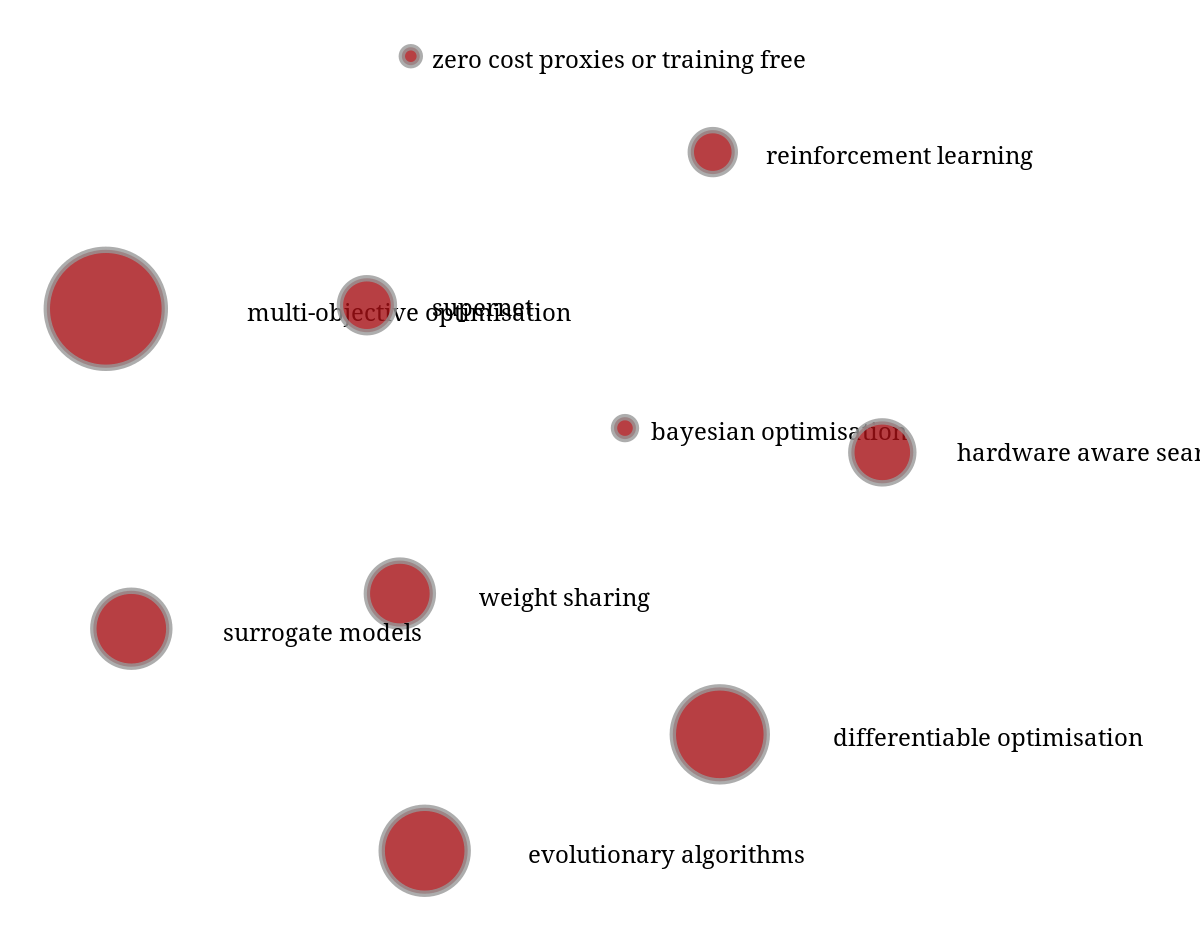

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x768a5735c7d0, at 0x768a5735df70>

In [10]:
gt.graph_draw(g, vertex_size=node_size, vertex_text=node_label, vertex_text_position=0, vertex_font_size=12)

In [11]:
couple2edge = {}
edge_weight = g.new_ep("int") 
# add edges
for key1, key2 in combinations(keywords, 2):
    e = g.add_edge(keyword2node[key1], keyword2node[key2])
    edge_weight[e] = (df_keywords[key1] & df_keywords[key2]).sum() // 10

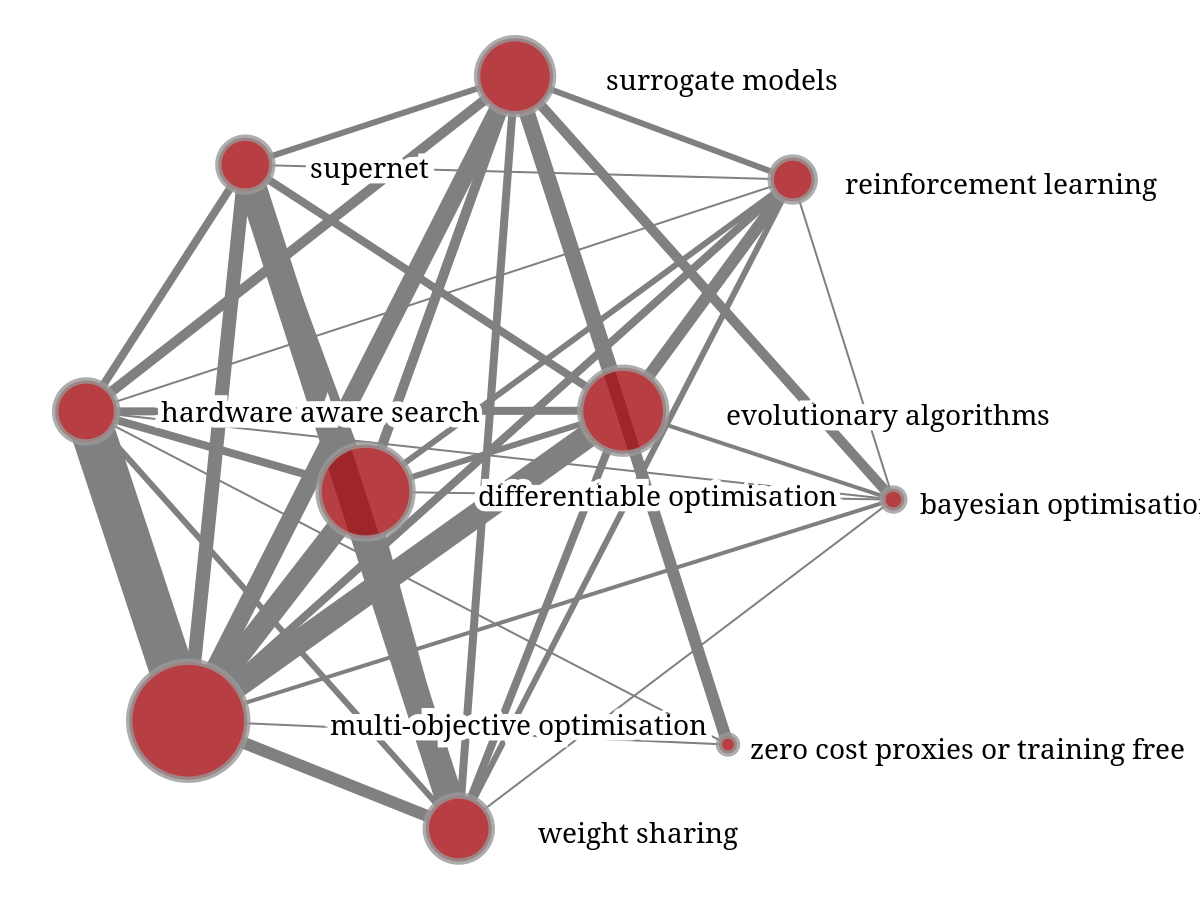

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x768a5735c7d0, at 0x768a5735fd10>

In [12]:
gt.graph_draw(g, vertex_size=node_size, vertex_text=node_label, vertex_text_position=0, vertex_font_size=14,
              vertex_text_out_color="white", vertex_text_out_width = 0.01,
              edge_pen_width=edge_weight, edge_color="gray")

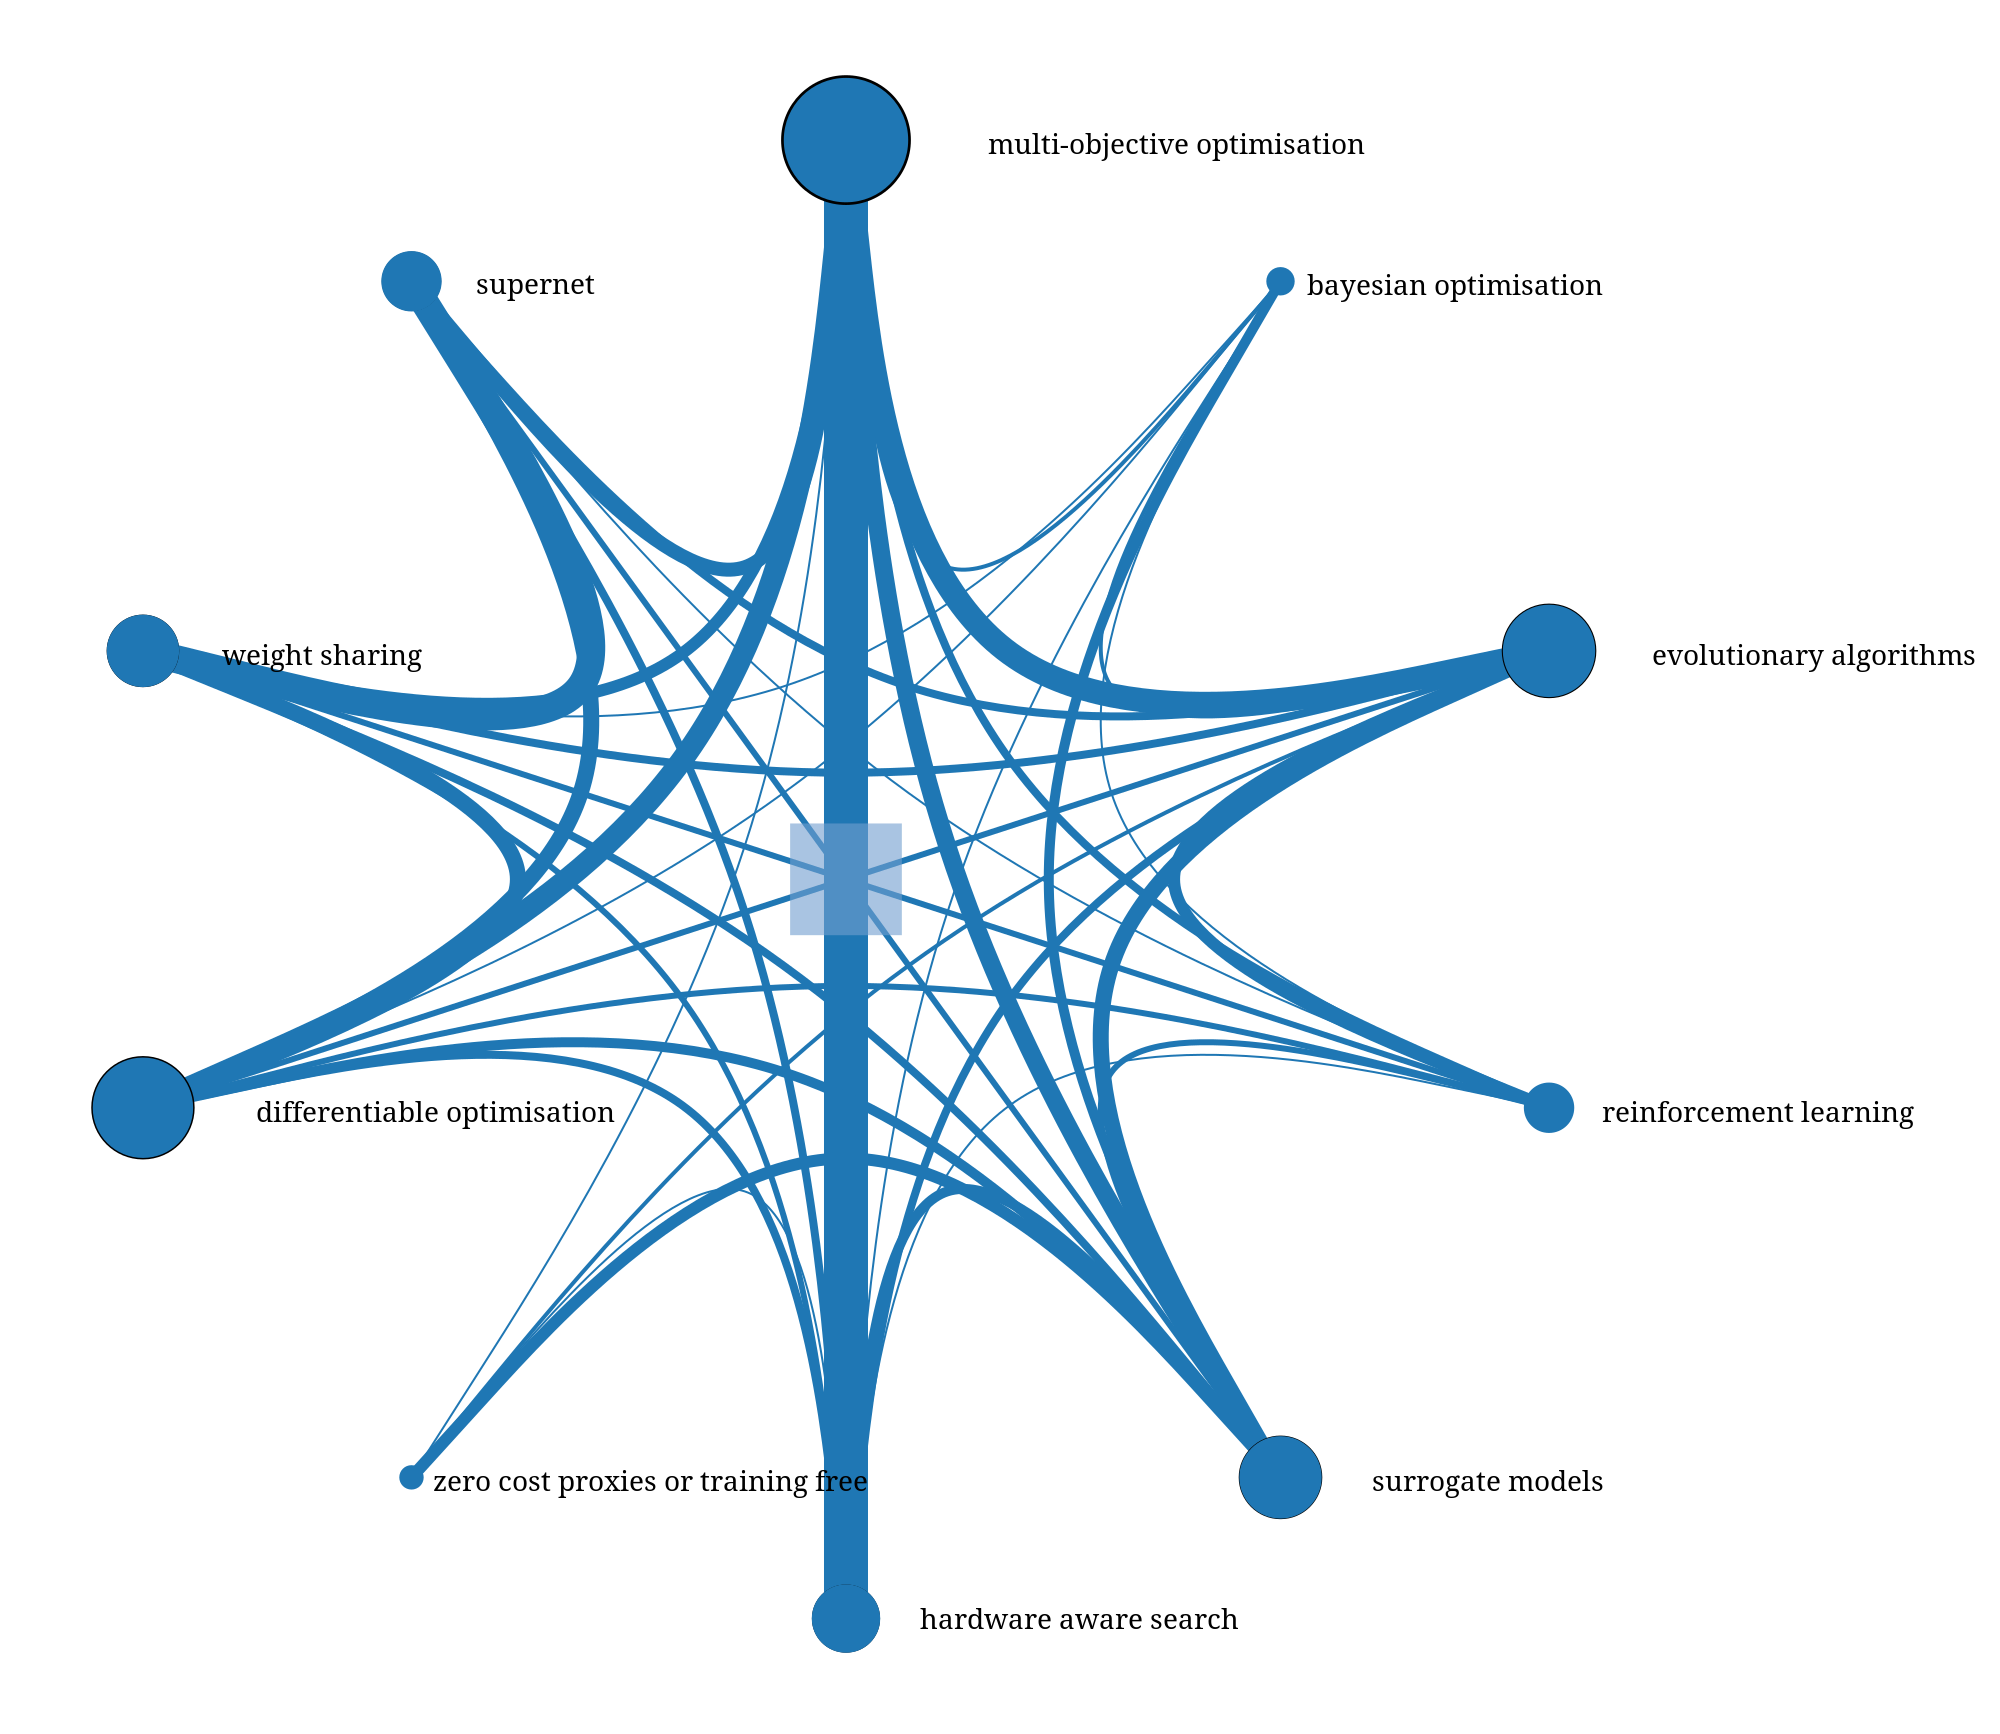

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x768a5735c7d0, at 0x768a571fb500>,
 <GraphView object, directed, with 11 vertices and 10 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x768a58bee510, at 0x768a55220110>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x768a58bee510, at 0x768a5520edb0>, False), at 0x768a58bee510>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x768a58bee510, at 0x768a5520dc10>)

In [13]:
state = gt.minimize_nested_blockmodel_dl(g)
state.draw(vertex_size=node_size, vertex_text=node_label,  vertex_text_position=0, vertex_font_size=14,
           vertex_halo=True, vertex_halo_color="black", vertex_halo_size=1.1,
           edge_color="lightblue", edge_pen_width=edge_weight, 
           output_size = (1000, 1000))

## LLM keywords

In [14]:
llm_keywords = read_keyword_lists(data_dir) 

In [15]:
set_of_keywords = set()
for small_set in llm_keywords.values():
    set_of_keywords.update(small_set)
len(set_of_keywords)

6399

In [22]:
keyword_papers = {keyword: [] for keyword in set_of_keywords}
for paper, small_set in llm_keywords.items():
    for key in small_set:
        keyword_papers[key].append(paper)
keyword_counts = {keyword: len(l) for keyword, l in keyword_papers.items()}

In [43]:
keyword2node = {}
g2 = gt.Graph(directed=False)
node_label = g2.new_vp("string")
show_label = g2.new_vp("string")
show_label2 = g2.new_vp("string")
node_size = g2.new_vp("int")
text_size = g2.new_vp("int")

for keyword in set_of_keywords:
    if keyword_counts[keyword] < 10:
        continue
    node = g2.add_vertex()
    keyword2node[keyword] = node
    node_label[node] = keyword
    show_label[node] = keyword if keyword_counts[keyword] > 50 else ""
    show_label2[node] = keyword if keyword_counts[keyword] > 10 else ""
    node_size[node] = 1 + keyword_counts[keyword] // 3
    text_size[node] = keyword_counts[keyword] // 5

In [44]:
sorted_keywords = sorted(list(set_of_keywords), key=lambda x: keyword_counts[x], reverse=True)
[(key, keyword_counts[key]) for key in sorted_keywords[:20]]


[('deep learning', 321),
 ('convolutional neural networks', 124),
 ('reinforcement learning', 120),
 ('deep neural networks', 111),
 ('evolutionary algorithms', 72),
 ('machine learning', 72),
 ('image classification', 65),
 ('graph neural networks', 63),
 ('hyperparameter optimization', 63),
 ('transfer learning', 63),
 ('differentiable architecture search', 61),
 ('accuracy', 56),
 ('bayesian optimization', 56),
 ('supernet', 54),
 ('pruning', 53),
 ('evolutionary algorithm', 50),
 ('quantization', 50),
 ('differentiable', 50),
 ('knowledge distillation', 50),
 ('model compression', 47)]

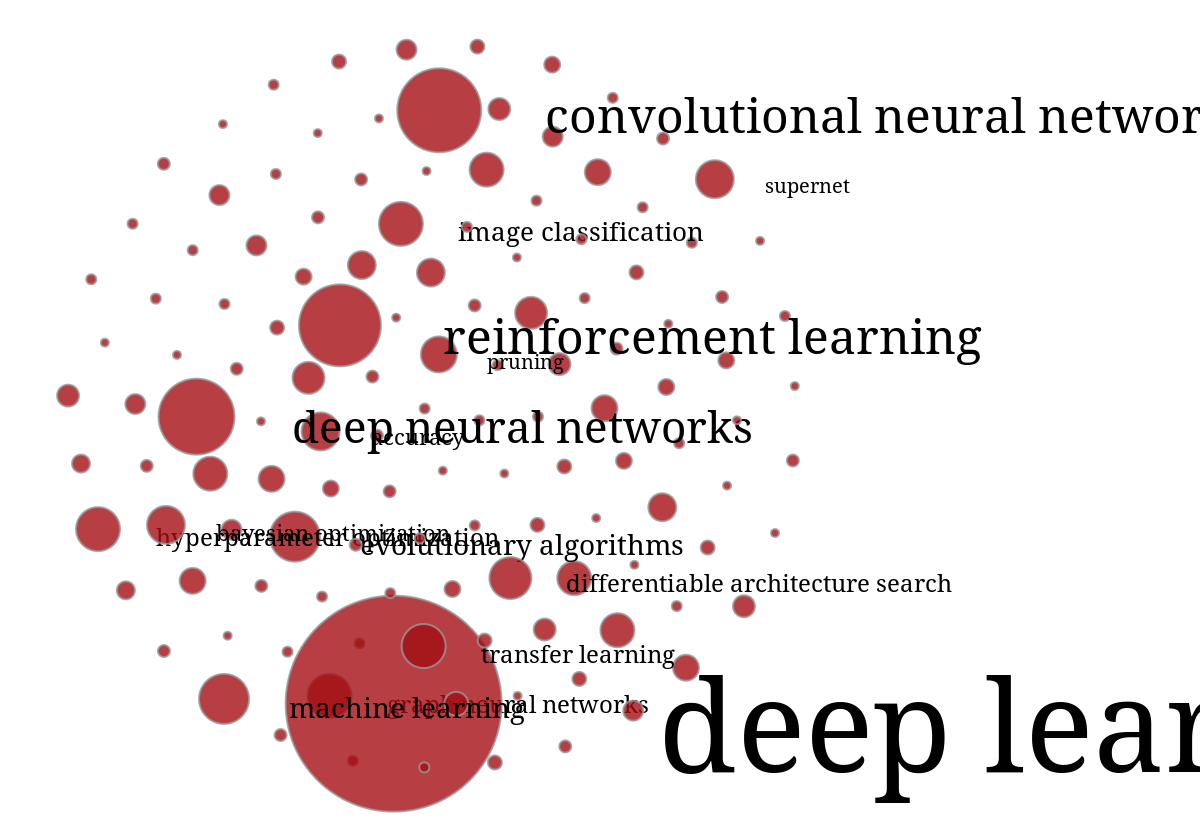

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x768a4d1e6180, at 0x768a4d1e5f10>

In [45]:
gt.graph_draw(g2, vertex_size=node_size, vertex_text=show_label, vertex_text_position=0, vertex_font_size=text_size,
             vertex_text_offset=(0.1,0.1))

In [46]:
edge_size = g2.new_ep("int")
#add edges
for node1, node2 in combinations(g2.vertices(), 2):
    key1, key2 = node_label[node1], node_label[node2]
    s1, s2 = set(keyword_papers[key1]), set(keyword_papers[key2])
    common = s1.intersection(s2)
    if len(common) > 0:
        e = g2.add_edge(node1, node2)
        edge_size[e] = len(common)
        

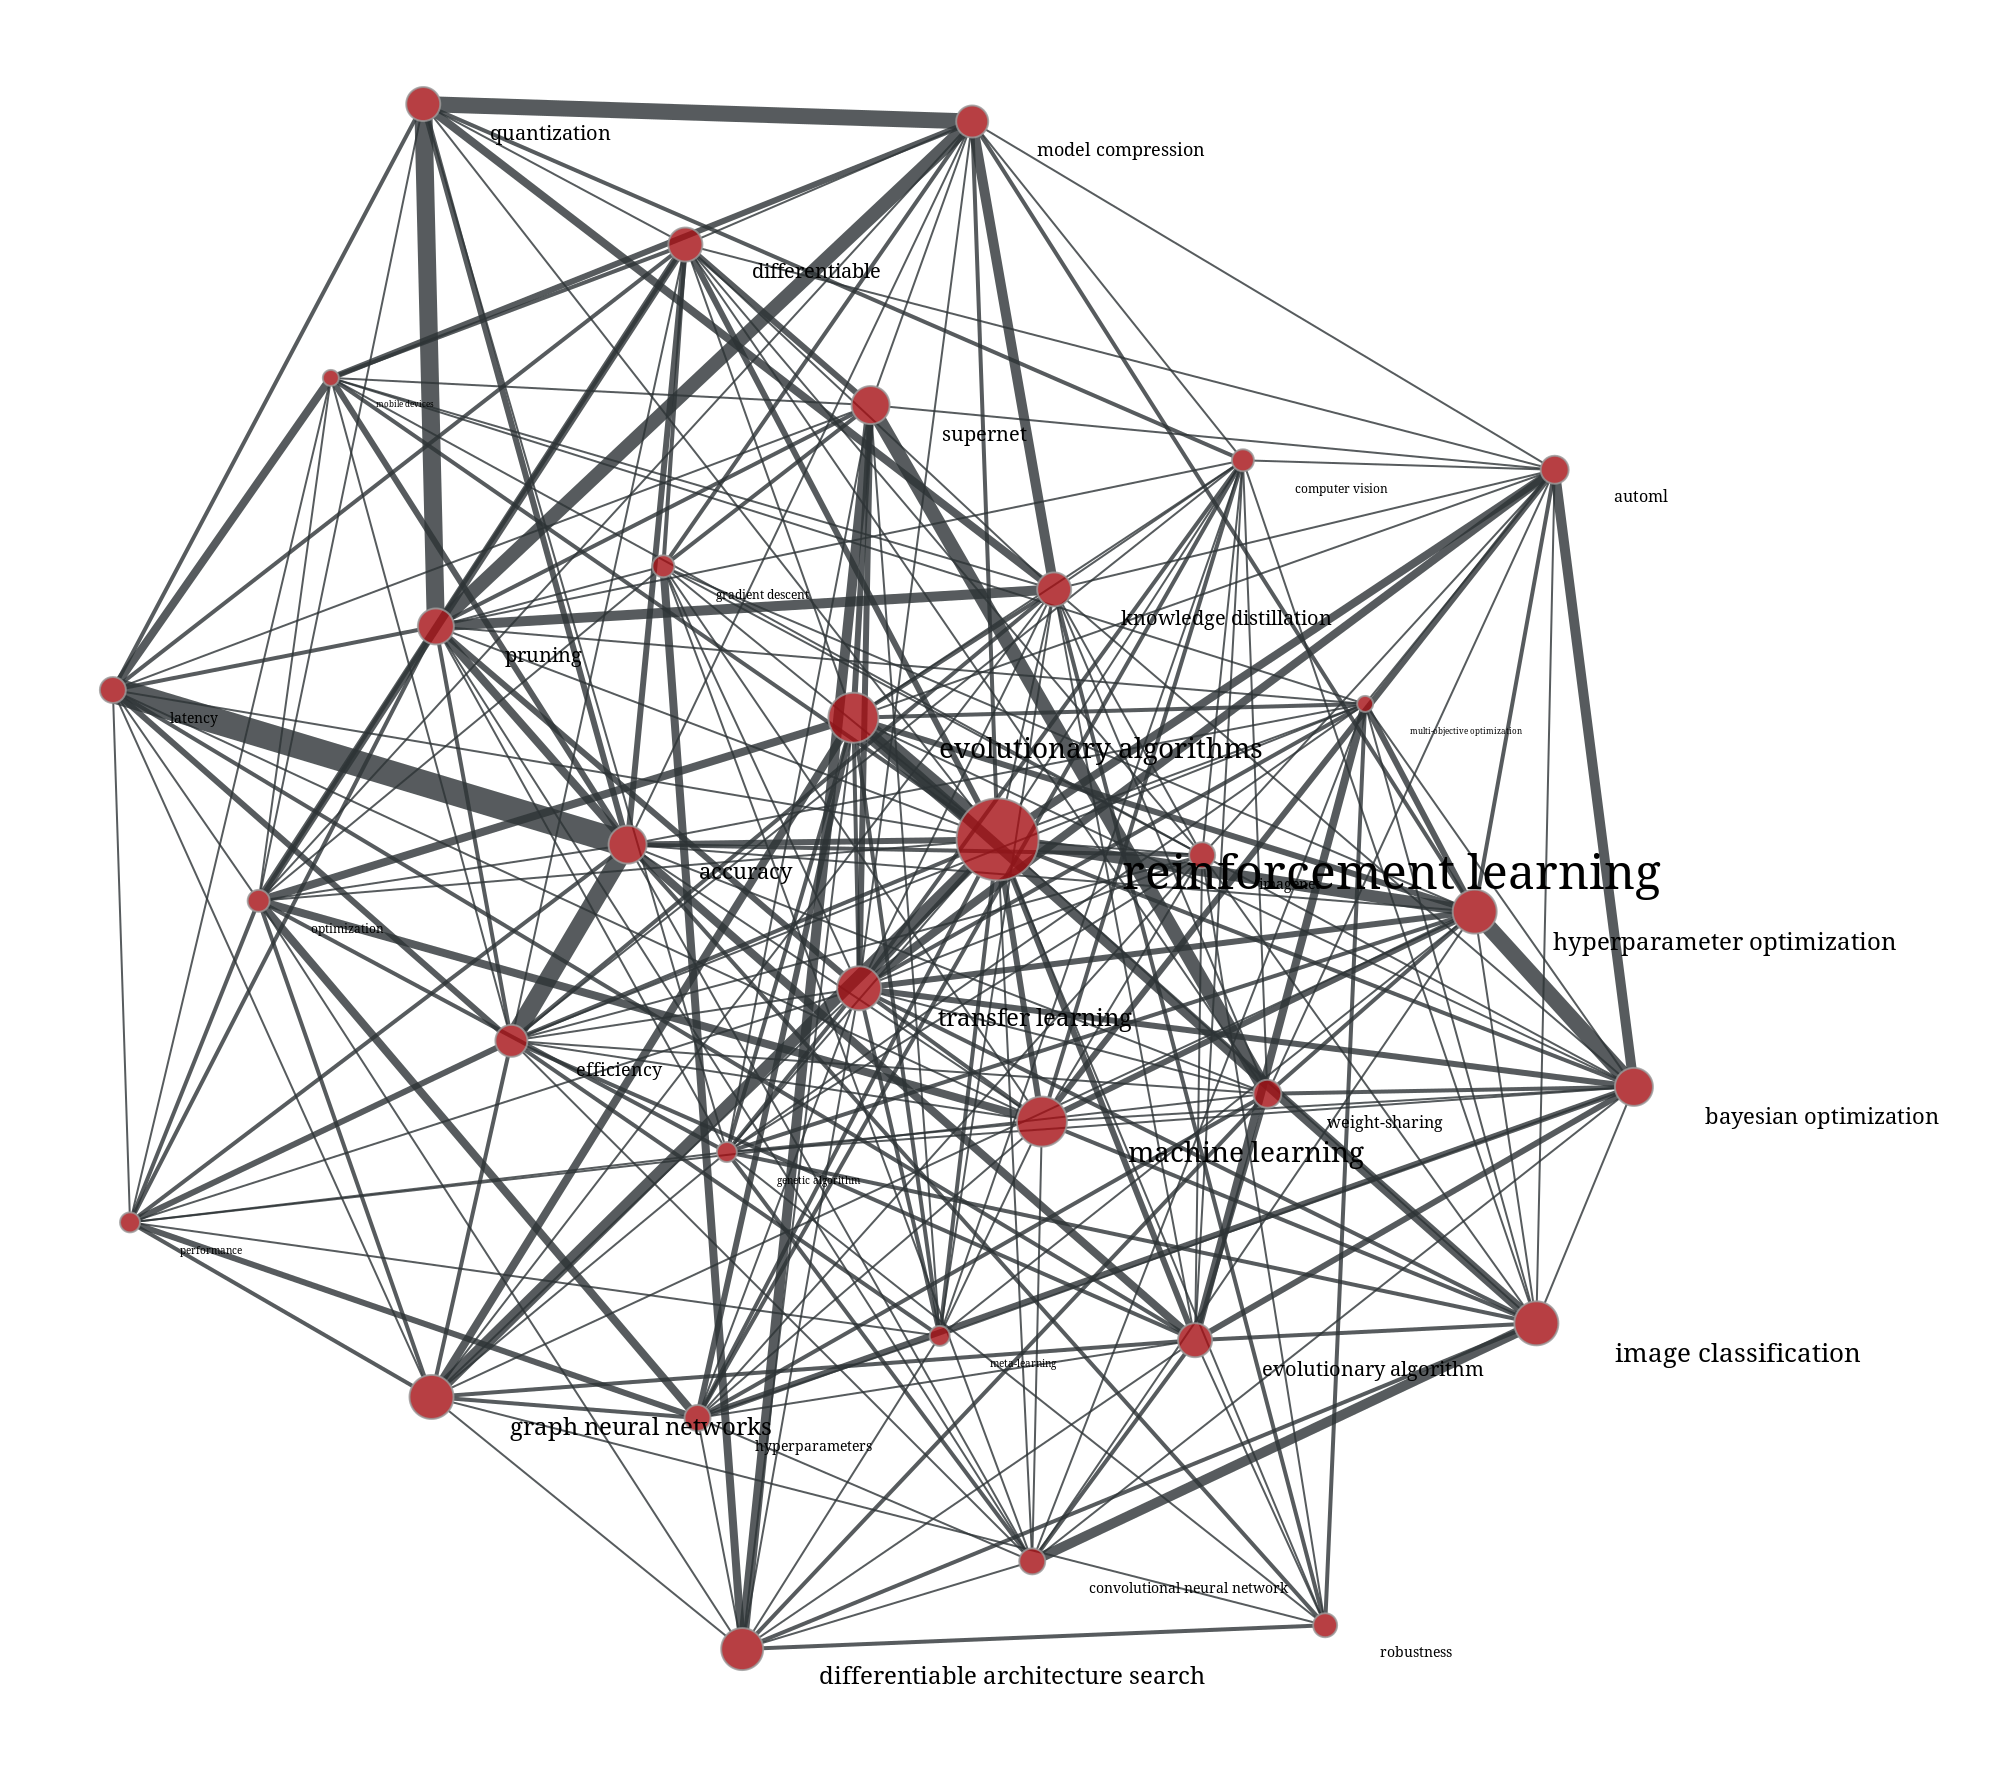

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x768a5735fda0, at 0x768a4d1db260>

In [49]:
forbidden_keys = ["deep learning", "deep neural networks", "convolutional neural networks"]
u = gt.GraphView(g2, vfilt=lambda v: v.in_degree() + v.out_degree() > 25)
u = gt.GraphView(u, vfilt=lambda v: node_label[v] not in forbidden_keys)

gt.graph_draw(u, vertex_size=node_size, vertex_text=show_label2, vertex_text_position=0, vertex_font_size=text_size,
             vertex_text_offset=(0.1,0.1),
             edge_pen_width = edge_size,
             output_size=(1000,1000))

In [50]:
state2 = gt.minimize_nested_blockmodel_dl(g2)

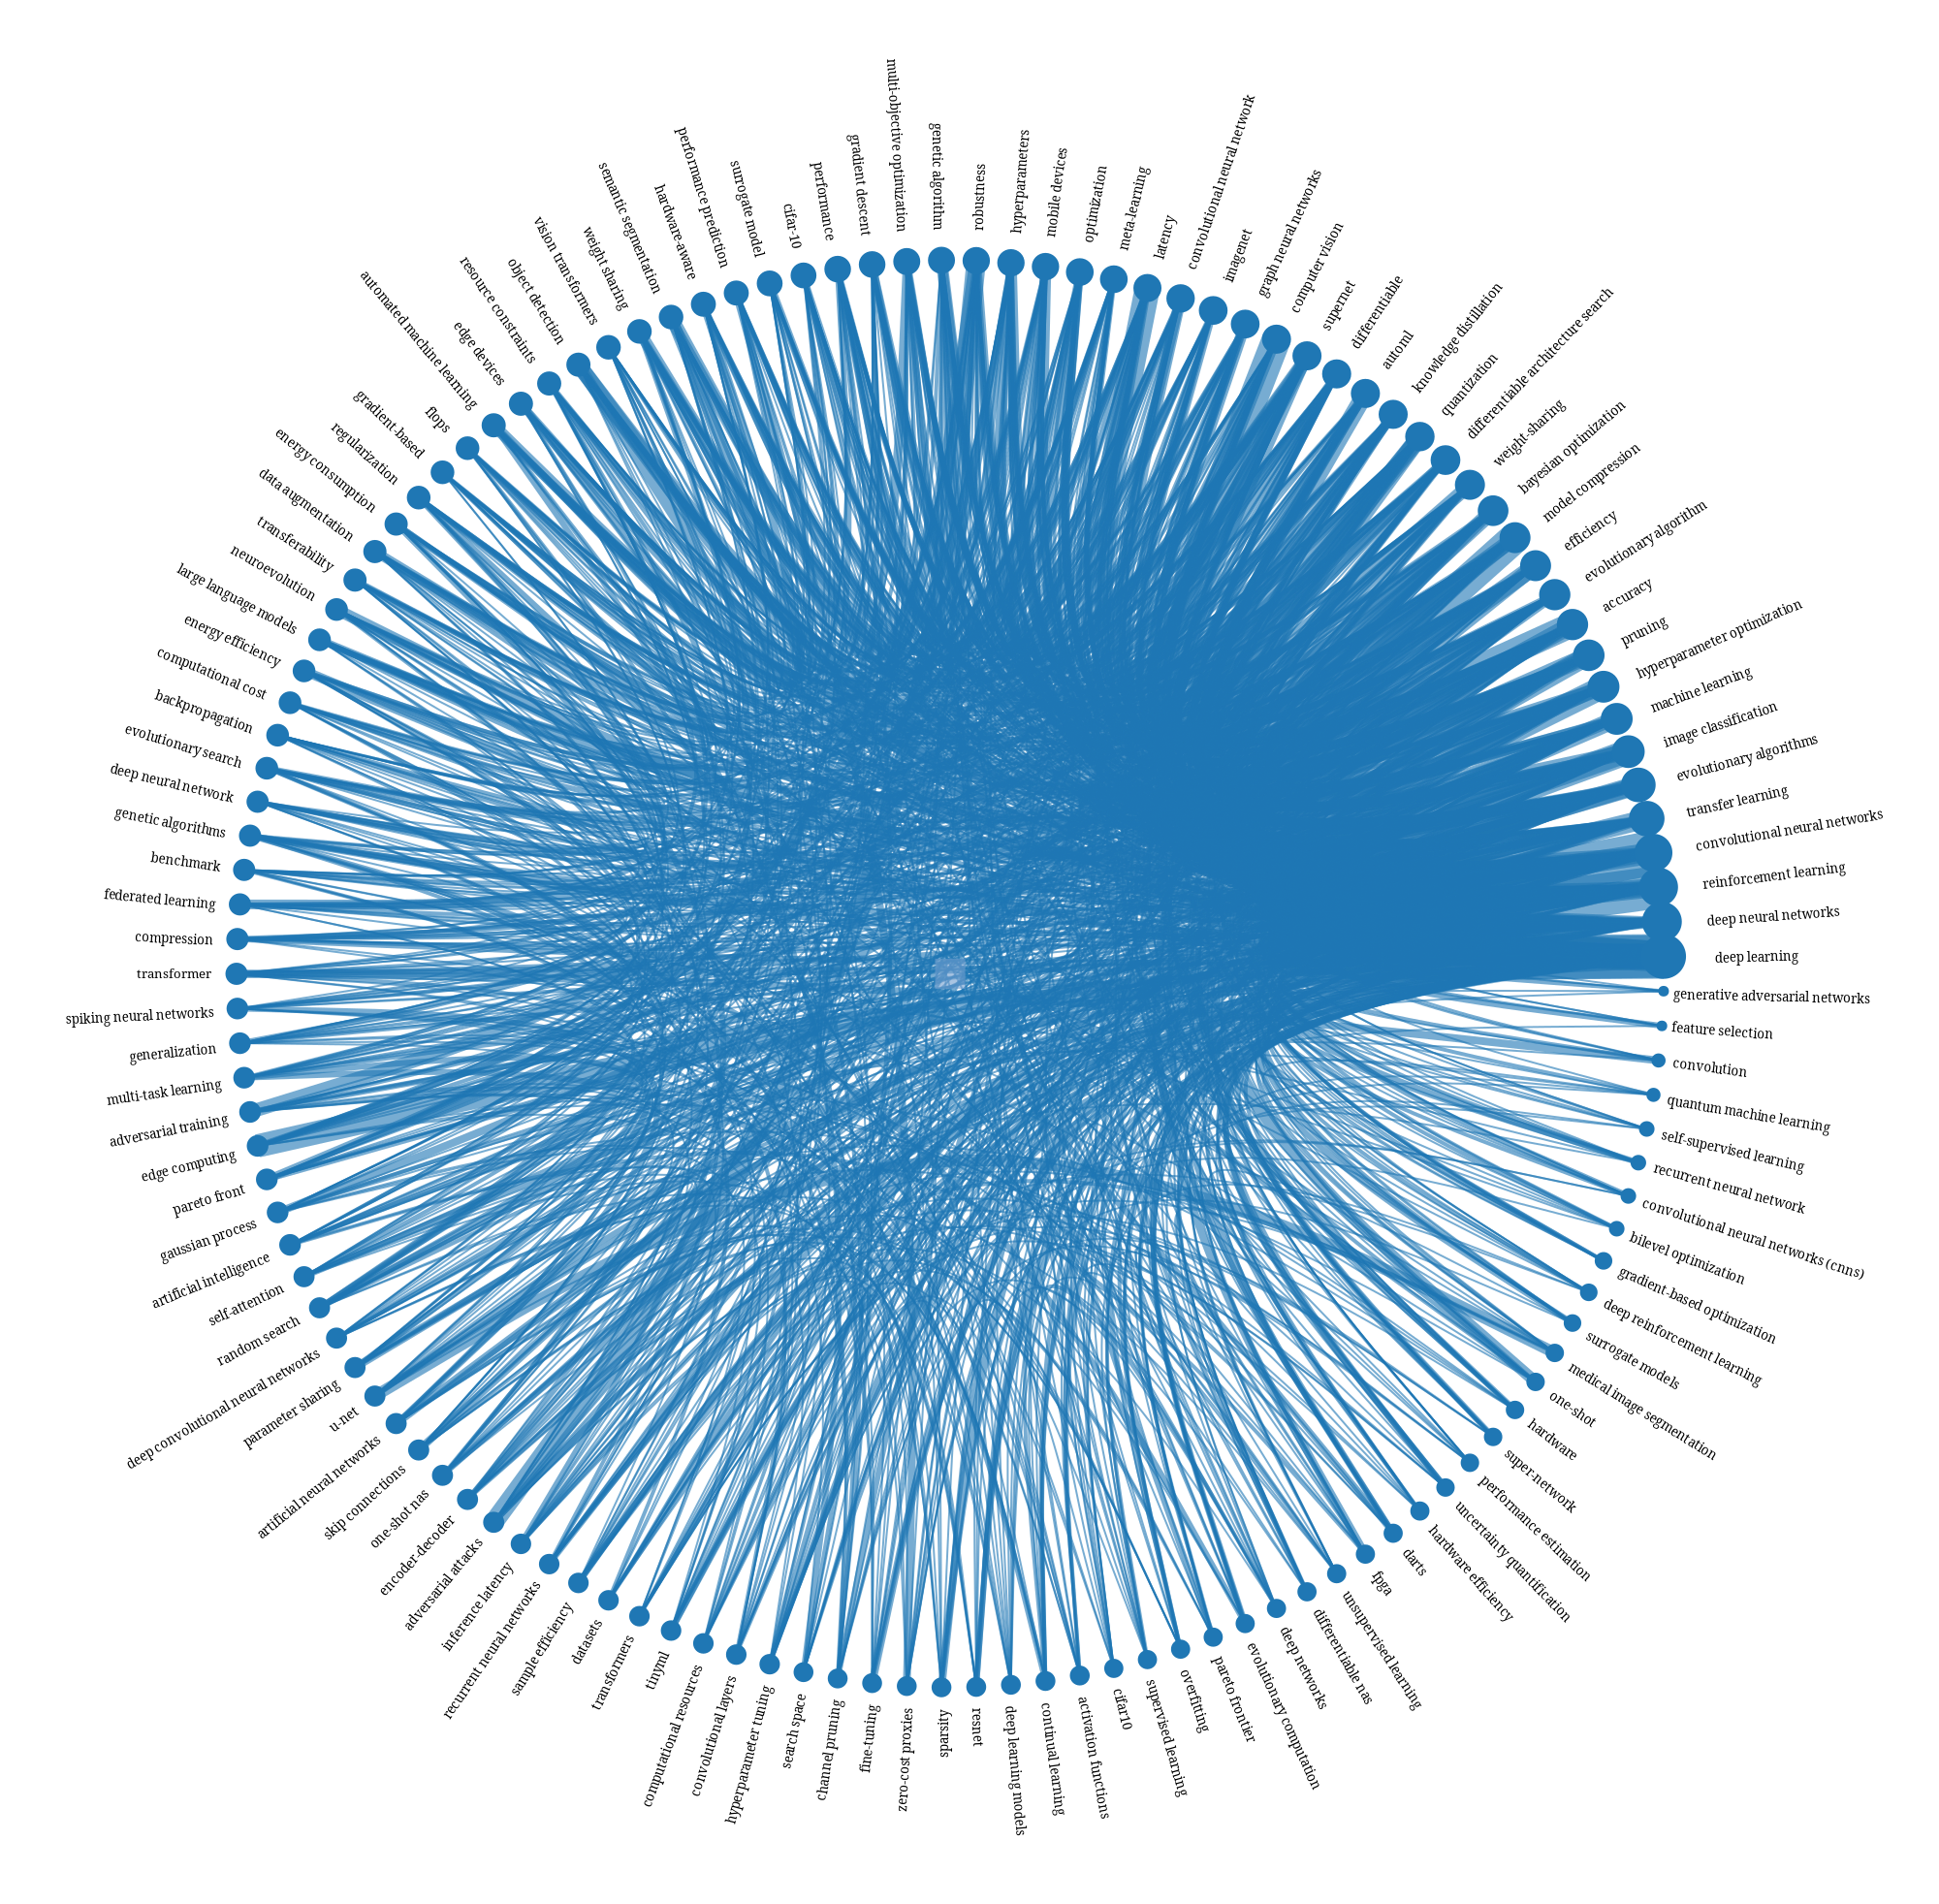

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x768a4d1e6180, at 0x768a5520d8b0>,
 <GraphView object, directed, with 130 vertices and 129 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x768a4d043b30, at 0x768a4d041610>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x768a4d043b30, at 0x768a4d043b00>, False), at 0x768a4d043b30>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x768a4d043b30, at 0x768a4d040b60>)

In [60]:
state2.draw(vertex_text=node_label, vertex_text_position="centered", output_size=(1000,1000),
           edge_pen_width=edge_size)

In [58]:
state2b = gt.minimize_nested_blockmodel_dl(u)

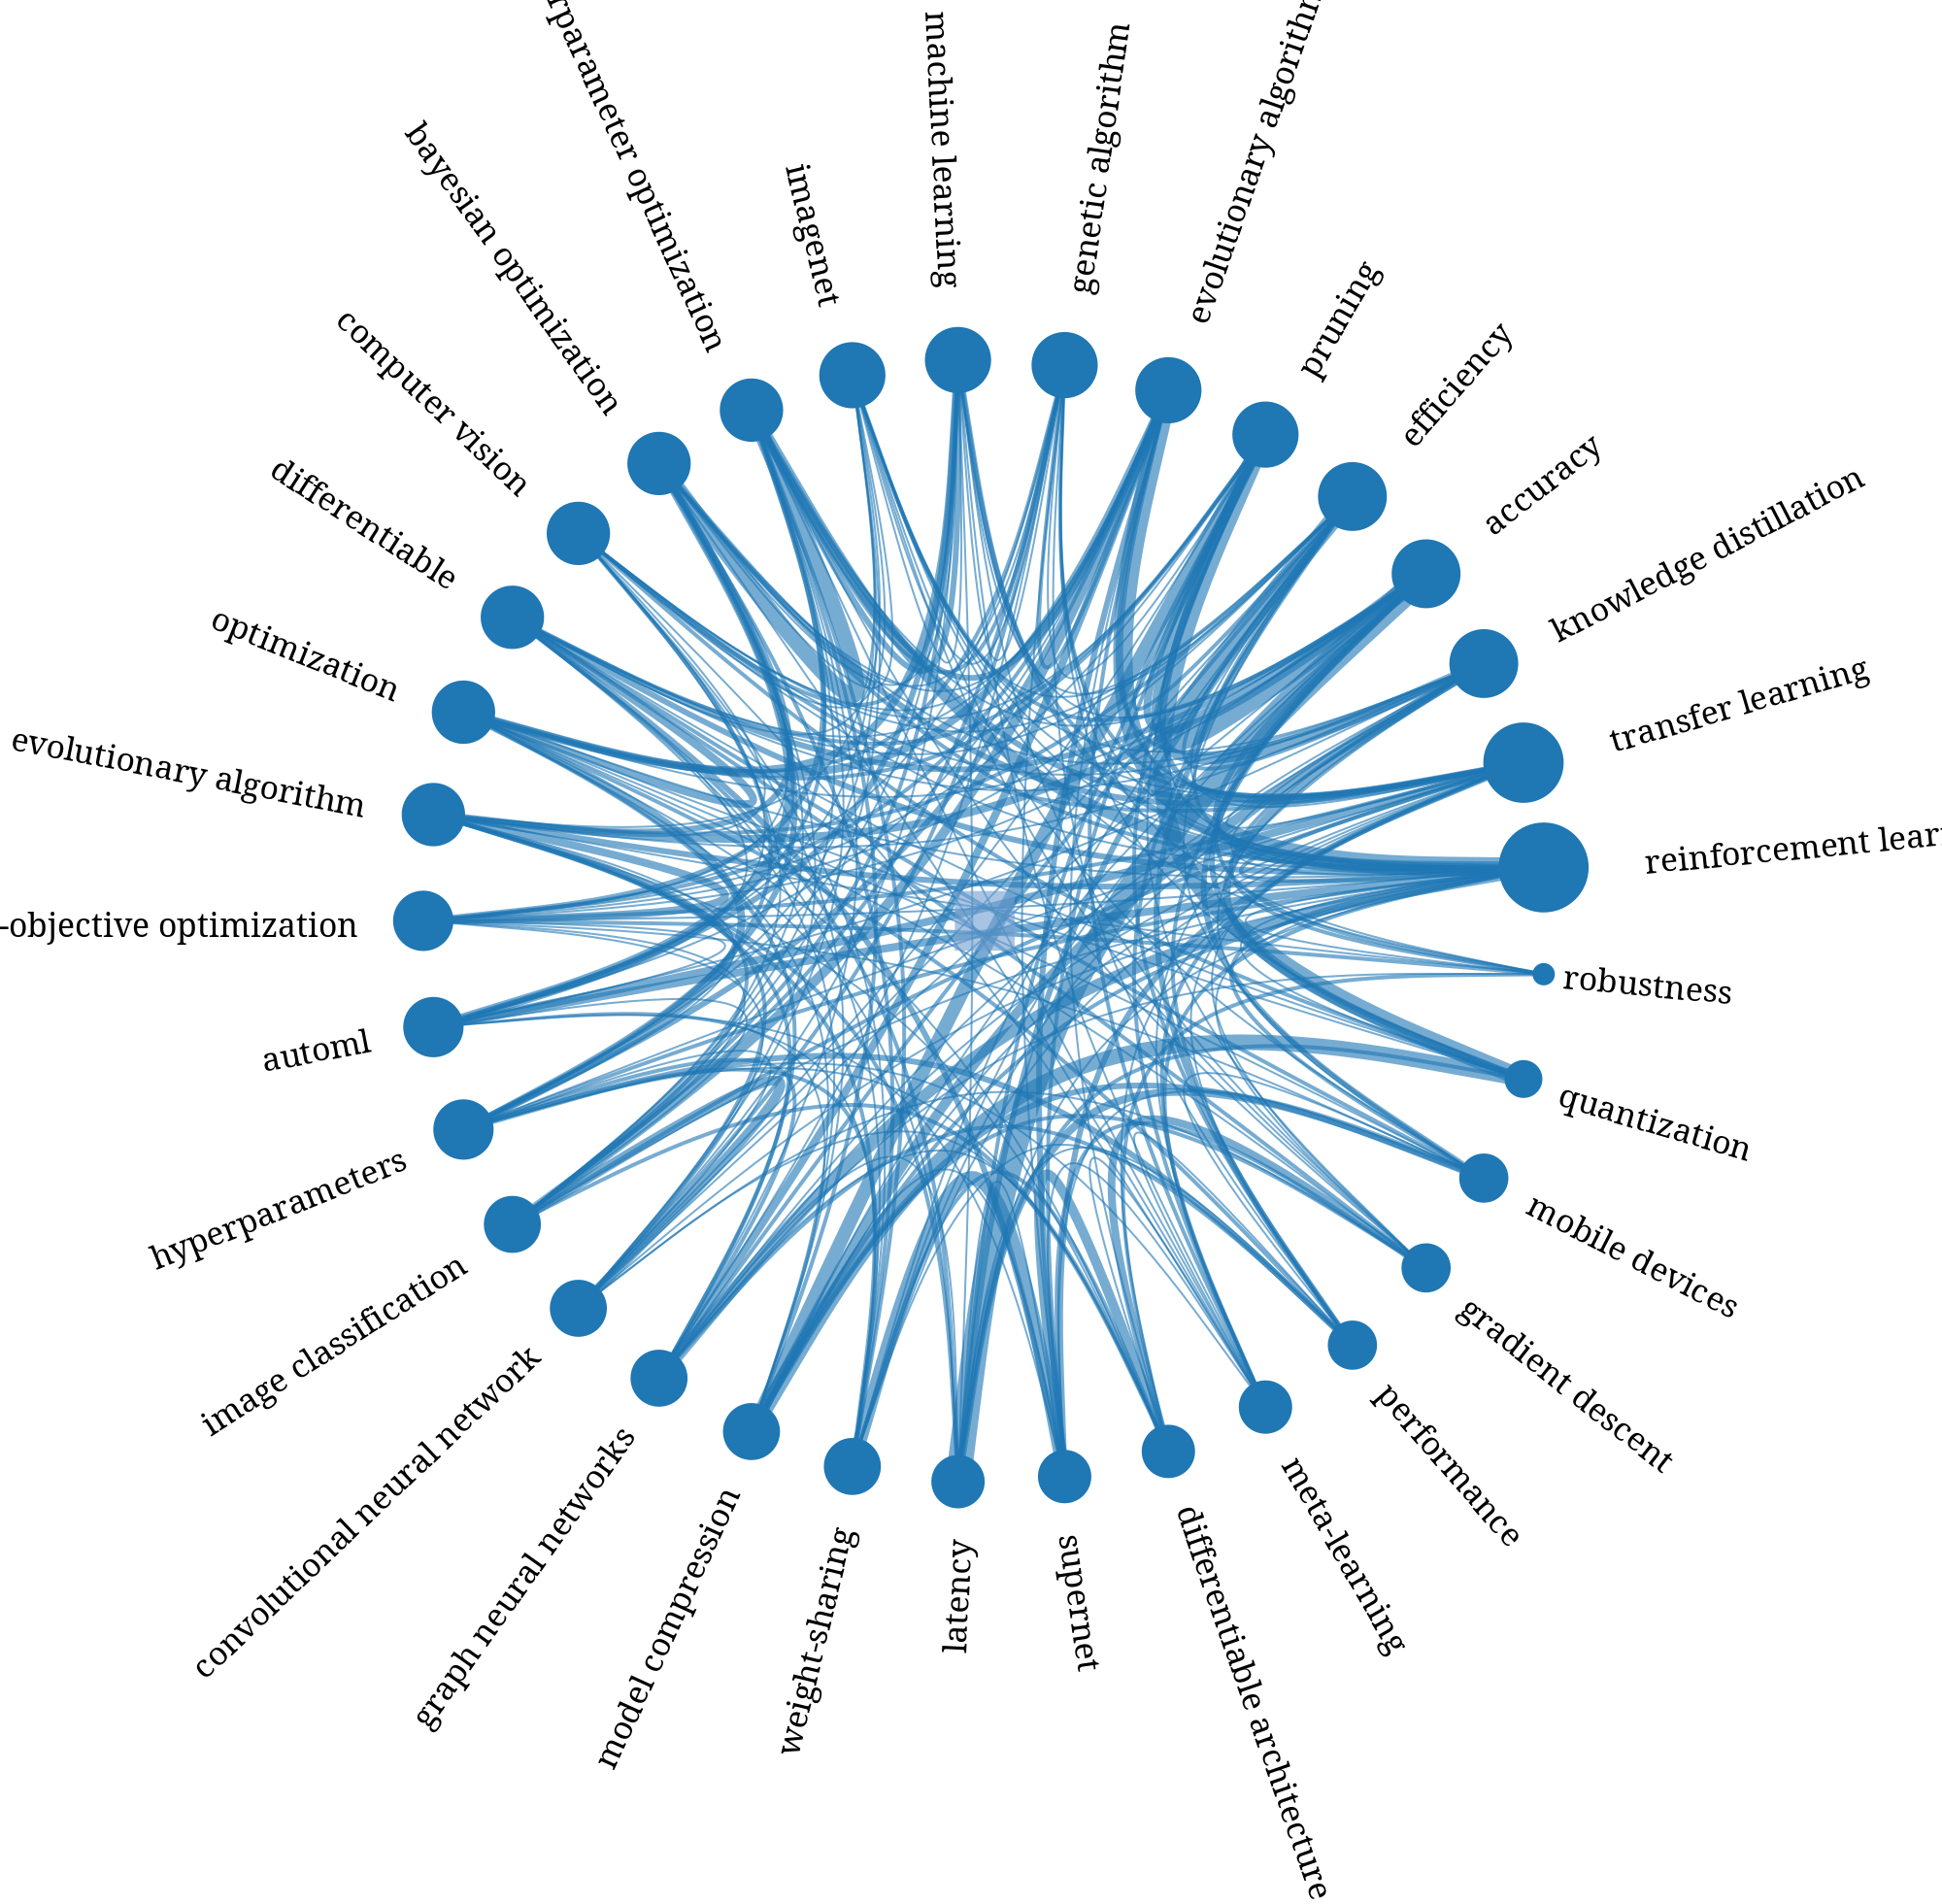

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x768a5735fda0, at 0x768a4d02db50>,
 <GraphView object, directed, with 34 vertices and 33 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x768a54293590, at 0x768a4d042210>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x768a54293590, at 0x768a4d041c40>, False), at 0x768a54293590>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x768a54293590, at 0x768a4d042960>)

In [61]:
state2b.draw(vertex_text=node_label, vertex_text_position="centered", output_size=(1000,1000),
            edge_pen_width=edge_size)